In [9]:
using Turing, Plots, Random, DelimitedFiles, DataFrames

In [2]:
Random.seed!(0);
#Generate data
T = 200

w1, w2 = 1, 10

y_data = [sqrt(1/w1)*randn()]
for t=2:50
    append!(y_data, y_data[end] + sqrt(1/w1)*randn())
end
for t=51:150
    append!(y_data, y_data[end] + sqrt(1/w2)*randn())
end
for t=151:T
    append!(y_data, y_data[end] + sqrt(1/w1)*randn())
end

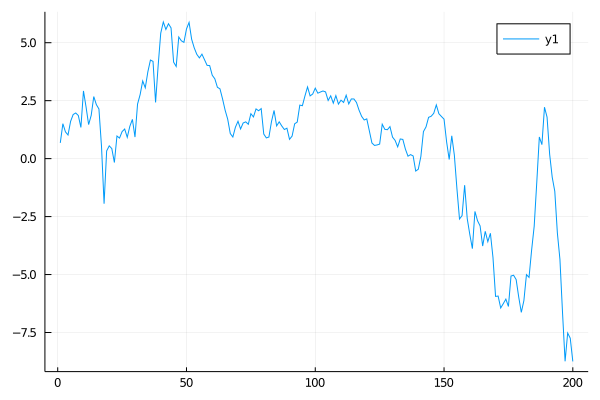

In [3]:
plot(y_data)

In [4]:
@model function SSSM(y)
    vars = [1, 0.1]
    T = length(y)
    z = tzeros(Int,T-1)
    x = Vector(undef, T)
    M = Vector{Vector}(undef,2) # Transition matrix
    M[1] ~ Dirichlet([100,1])
    M[2] ~ Dirichlet([1,100])
    
    z[1] ~ Categorical(2)
    x[1] ~ Normal()
    y[1] ~ Normal(x[1],sqrt(0.1))
    for t = 2:T-1
        x[t] ~ Normal(x[t-1],sqrt(vars[z[t-1]]))
        y[t] ~ Normal(x[t],sqrt(0.1))
        z[t] ~ Categorical(vec(M[z[t-1]]))
    end
    x[T] ~ Normal(x[T-1],sqrt(vars[z[T-1]]))
    y[T] ~ Normal(x[T],sqrt(0.1))
end

SSSM (generic function with 1 method)

In [5]:
gibbs = Gibbs(NUTS(1000,0.65,:x,:M),PG(50,:z))
chain = sample(SSSM(y_data),gibbs,100)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/sakbayrak/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:10


Chains MCMC chain (100×404×1 Array{Float64,3}):

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = M[1][1], M[1][2], M[2][1], M[2][2], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19], x[20], x[21], x[22], x[23], x[24], x[25], x[26], x[27], x[28], x[29], x[30], x[31], x[32], x[33], x[34], x[35], x[36], x[37], x[38], x[39], x[40], x[41], x[42], x[43], x[44], x[45], x[46], x[47], x[48], x[49], x[50], x[51], x[52], x[53], x[54], x[55], x[56], x[57], x[58], x[59], x[60], x[61], x[62], x[63], x[64], x[65], x[66], x[67], x[68], x[69], x[70], x[71], x[72], x[73], x[74], x[75], x[76], x[77], x[78], x[79], x[80], x[81], x[82], x[83], x[84], x[85], x[86], x[87], x[88], x[89], x[90], x[91], x[92], x[93], x[94], x[95], x[96], x[97], x[98], x[99], x[100], x[101], x[102], x[103], x[104], x[105], x[106], x[107], x[108], x[109], x[110], x[111], x[112], x[113], x[114

In [6]:
mean(group(chain,:M).value.data, dims=1)

1×4×1 Array{Float64,3}:
[:, :, 1] =
 0.997445  0.00255516  0.00861031  0.99139

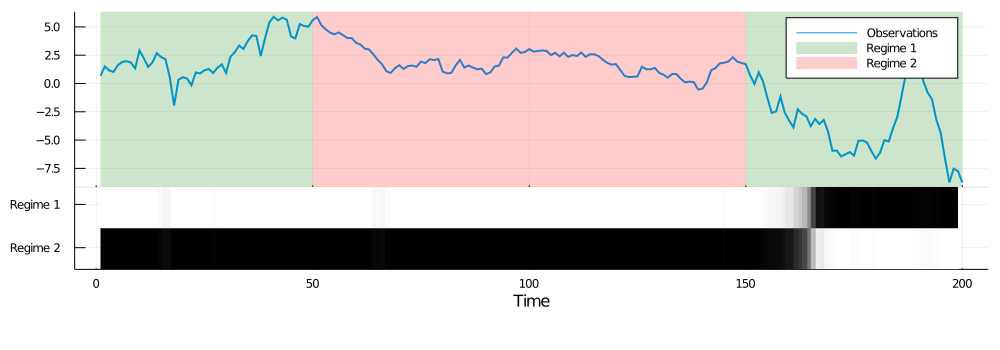

In [7]:
m_z = reshape(mean(group(chain,:z).value.data, dims=1),199) .- 1

estimate = zeros(20,T-1)
for i=1:10
    estimate[i,:] = m_z
    estimate[i+10,:] = 1 .- m_z
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:200, y_data, w=2, labels = "Observations", legend=(:best))
vspan!(p1,[1,50], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[50,150], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[150,T], color = :green, alpha = 0.2, labels = "");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-20.0mm)
yticks!([5:10:15;], ["Regime 1", "Regime 2"])

p = plot(p1, p2, layout = l, size = (1000, 350))

In [10]:
writedlm("NUTSestimates.txt", estimate)